In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as spopt
from Wavenumbers_components import *
from cvt import *
from cvt_bfgs import *
from wavenumers_bfgs import *

# Data and preprocessing

## Data

In [2]:
# Data
x_diffraction_pt = np.array([5000, -3000]) # difraction point, fixed throughout the notebook

start = 0
stop = 10000

c0 = 2000 # velocity of the medium
#c0 = 1
f0 = c0/(2*np.pi) # it's f_0; is f0 = f_0?
k0 = 2*np.pi*f0/c0

# We compute the maximum angle \phi_max that \phi_s and \phi_r can take; will be useful for 
# later angular and circular arcs formulations of the wavenumber components 
s = np.array([start, 0])
ps = x_diffraction_pt - s
ps = ps/np.linalg.norm(ps)

phi_max = np.arccos(np.inner(ps, np.array([0, -1]))) 
phi_limits = np.array([- phi_max, phi_max])
limits, empty = angles2layout(phi_limits, np.array([]), x_diffraction_pt)
phi_max_enveloppe = 1.03*phi_max
phi_limits_enveloppe = np.array([- phi_max_enveloppe, phi_max_enveloppe])

m = 10 # number of sources
n = 10 # number of receivers
# We can use bounds for L-BFGS-B ( the method tends to produce errors)
Bounds = [ np.array([-phi_max, phi_max]) for i in range(n + m)]

In [3]:
np.rad2deg(phi_max)

59.03624346792648

## Construction of the domain

In [4]:
W = domain_construction(phi_limits_enveloppe, k0)
W_tight = domain_construction(phi_limits, k0)

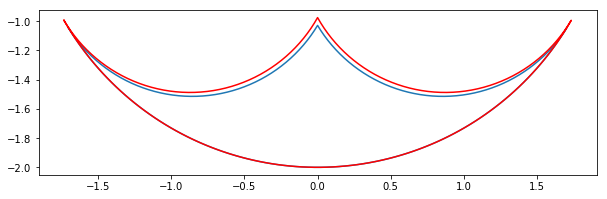

True

In [5]:
# Vizualization of the validity of the polygons
S = Polygon(np.array(W_tight))
S2 = Polygon(np.array(W))
plt.figure(figsize = (10, 10))
ax = plt.gca()
ax.set_aspect('equal')
ax.plot(*S.exterior.xy)
ax.plot(*S2.exterior.xy, color = 'r')
plt.show()
S.is_valid

# Optimization of the wavenumbers

# Random angles as an initialization of the acquisition

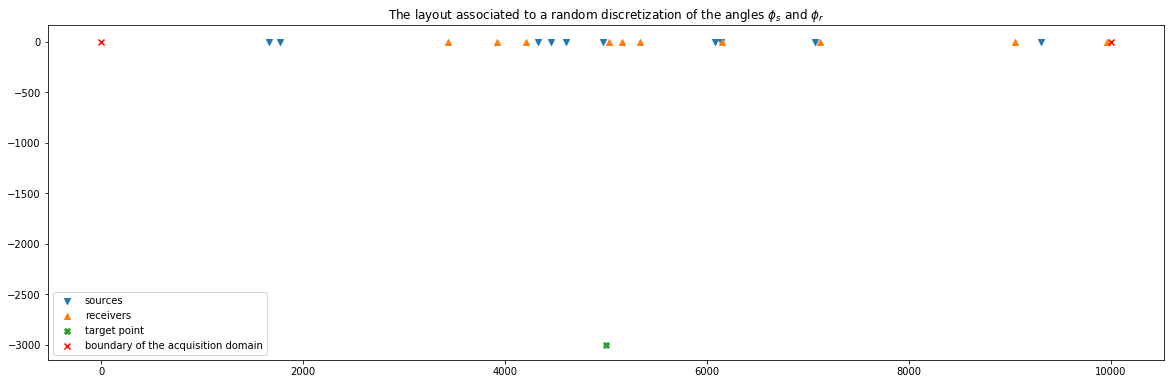

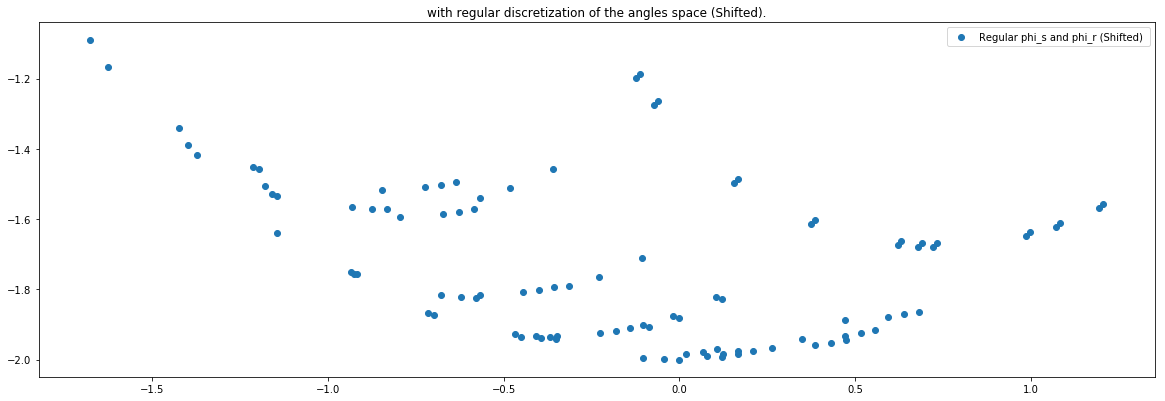

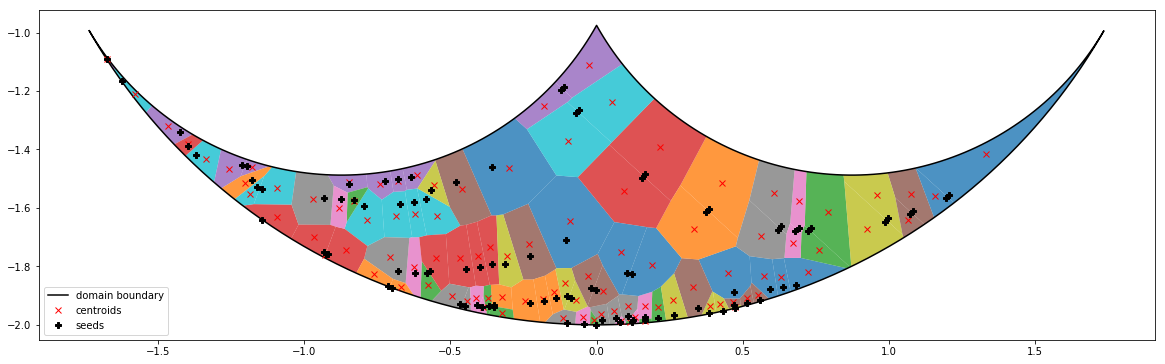

In [6]:
#shift = 0.5*phi_max/n
Phi_random = np.random.uniform(-phi_max, phi_max, size = n + m)
phiS_random = Phi_random[:m]
phiR_random = Phi_random[m:]

S_random, R_random = angles2layout(phiS_random, phiR_random, x_diffraction_pt)

plot_disposition(S_random, R_random, x_diffraction_pt, title = "The layout associated to a random discretization of the angles $\phi_s$ and $\phi_r$", limits = limits)

# We compute the wavenumbers components of reference
K_random = wavenumbers_components(x_diffraction_pt, S_random, R_random, c0, f0, method = "132_modified")
plot_scatter(K_random, "Regular phi_s and phi_r (Shifted) ", title = "with regular discretization of the angles space (Shifted).", color = 'steelblue')
seeds, regions = voronoi_domain(K_random, W)
plot_voronoi_domain(seeds, W, regions)

# Choose which acquisition to select as initialization
initial_Phi = Phi_random
initial_K = K_random

### Lloyd

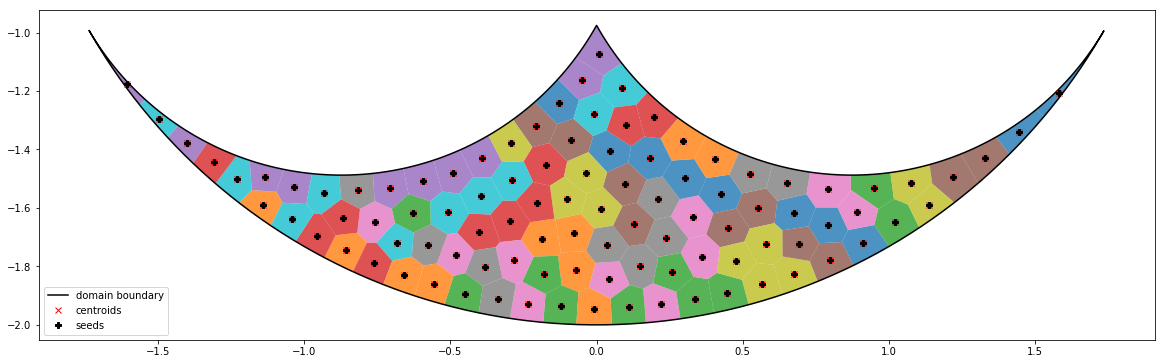

In [7]:
lloyd_seeds, lloyd_regions = Lloyd(initial_K, W)
plot_voronoi_domain(lloyd_seeds, W, lloyd_regions)

Optimization terminated successfully.
         Current function value: 0.002763
         Iterations: 276
         Function evaluations: 278
         Gradient evaluations: 278
Success:  True
Number of iterations:  276


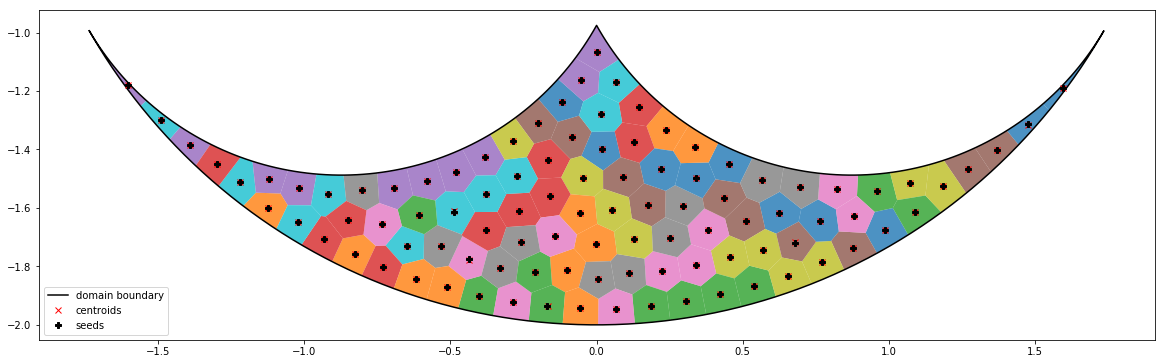

In [8]:
bfgs = spopt.minimize(F, initial_K, method = 'BFGS', jac = grad_F, args = (W,), options = {'disp':True})
bfgs_seeds, bfgs_regions = voronoi_domain(bfgs['x'], W)
print('Success: ', bfgs['success'])
print('Number of iterations: ', bfgs['nit'])
plot_voronoi_domain(bfgs_seeds, W, bfgs_regions)

In [9]:
bfgs

      fun: 0.0027632078272272586
 hess_inv: array([[ 35.56587387,  -1.38571977,  23.31997254, ...,  -0.68868302,
         12.24043203,  -8.07928989],
       [ -1.38571977,  23.50028568,   2.53934934, ...,   3.02084325,
          6.43272772,  -3.45562033],
       [ 23.31997254,   2.53934934,  50.09880513, ...,   3.73849403,
         34.2718118 , -18.98441162],
       ...,
       [ -0.68868302,   3.02084325,   3.73849403, ...,  26.36259098,
          3.10331604,  -5.17313816],
       [ 12.24043203,   6.43272772,  34.2718118 , ...,   3.10331604,
         42.1614331 , -18.55538502],
       [ -8.07928989,  -3.45562033, -18.98441162, ...,  -5.17313816,
        -18.55538502,  15.59622375]])
      jac: array([-2.72779560e-07,  3.50416834e-07, -9.15586483e-07,  5.15243448e-06,
        4.83237564e-06, -1.76540892e-06,  1.74764369e-06,  1.09393161e-07,
        1.33992308e-06, -2.42774485e-06,  5.84046193e-06, -4.46827926e-08,
        8.88695459e-07, -3.52594799e-06, -4.30245620e-06, -1.90132542e-

In [10]:
F(K_random, W)

0.015066528710877105

### BFGS

In [11]:
bfgs = spopt.minimize(FoK, initial_Phi, method = 'BFGS', jac = grad_FoK, args = (W, c0, f0, m))
print("Succes: ", bfgs['success'])
print('Number of iterations: ', bfgs['nit'])
PhiS_bfgs, PhiR_bfgs = Phi_extraction(bfgs['x'], m)
K_bfgs = wavenumbers_components_angles(PhiS_bfgs, PhiR_bfgs, c0, f0)
bfgs_seeds, bfgs_regions = voronoi_domain(K_bfgs, W)
plot_voronoi_domain(bfgs_seeds, W, bfgs_regions)

Succes:  True
Number of iterations:  67


In [12]:
bfgs

      fun: 0.004074611253495524
 hess_inv: array([[70.09015831, 33.08097508, 24.55666688, 55.70758537, 57.58442111,
        10.51432272, 48.87522243,  2.45045433,  6.45954911, 38.08095652,
        15.59683217, 42.13363524, 51.90127633, 23.53735821, -0.65988755,
        23.94789665, 53.22522854, 48.72284612, 40.79162725, 10.39291313],
       [33.08097508, 41.99257435,  7.86353017, 26.39074769, 21.64058345,
         2.56435318, 34.33684878,  4.00837552, 11.10762193, 12.35614263,
        22.34243376, 16.3044537 , 34.17522484,  9.53318816, -1.58878039,
        29.07053643, 28.96959844, 15.80232679, 38.86916806,  2.29277633],
       [24.55666688,  7.86353017, 28.88017357, 27.24431844, 31.41026011,
        12.45517193, 12.90674391,  0.99297227,  1.73474629, 32.70617104,
         0.10471529, 17.34830818,  7.82649974, 15.10257805, -1.12512066,
         2.38969084, 16.0973738 , 17.32779052,  5.4198651 ,  8.1139465 ],
       [55.70758537, 26.39074769, 27.24431844, 69.5440998 , 55.53560231,
     

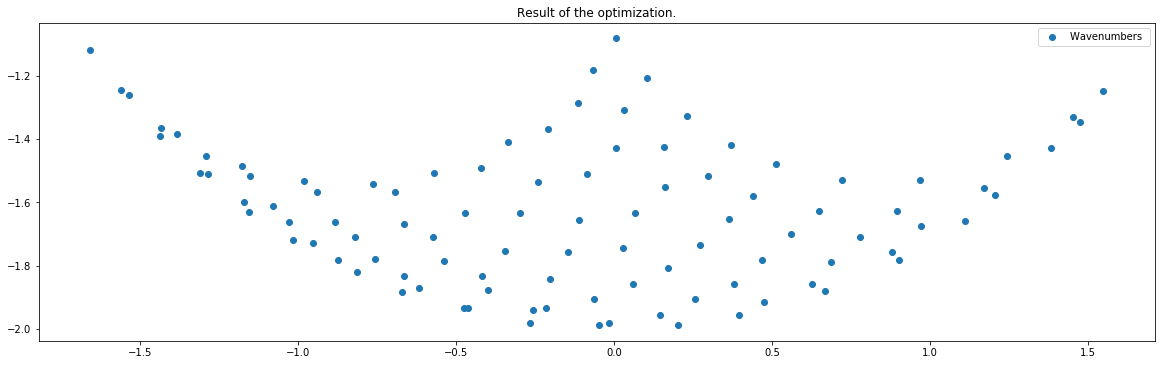

In [13]:
plot_optimization_result(bfgs['x'], m, limits, x_diffraction_pt, c0, f0)

### L-BFGS-B

In [14]:
l_bfgs_b = spopt.minimize(FoK, initial_Phi, method = 'L-BFGS-B', jac = grad_FoK, args = (W, c0, f0, m), bounds = Bounds)
print("Succes: ", l_bfgs_b['success'])
print('Number of iterations: ', l_bfgs_b['nit'])
PhiS_l_bfgs_b, PhiR_l_bfgs_b = Phi_extraction(l_bfgs_b['x'], m)
K_l_bfgs_b = wavenumbers_components_angles(PhiS_l_bfgs_b, PhiR_l_bfgs_b, c0, f0)
l_bfgs_b_seeds, l_bfgs_b_regions = voronoi_domain(K_l_bfgs_b, W)
plot_voronoi_domain(l_bfgs_b_seeds, W, l_bfgs_b_regions)

Succes:  True
Number of iterations:  25


In [15]:
#l_bfgs_b

In [16]:
plot_optimization_result(l_bfgs_b['x'], m, limits, x_diffraction_pt, c0, f0)

In [17]:
print("=========== Wavenumbers W ==========")
print("---------------- value of the objective function --------------------")
print("Initial fct value: ", F(initial_K, W))
print("Lloyd fct value: ", F(lloyd_seeds, W))
print("bfgs fct value: ", F(bfgs_seeds, W))
print("l_bfgs_b fct value: ", F(l_bfgs_b_seeds, W))
print("---------------- 2-norm of the gradient --------------------")
print("Initial fct gradient: ", np.linalg.norm( grad_F(initial_K, W) ) )
print("Lloyd fct gradient: ", np.linalg.norm( grad_F(lloyd_seeds, W)) )
print("bfgs fct gradient: ", np.linalg.norm( grad_F(bfgs_seeds, W)) )
print("l_bfgs_b fct gradient: ", np.linalg.norm( grad_F(l_bfgs_b_seeds, W)) )

=========== Wavenumbers W ==========
---------------- value of the objective function --------------------
Initial fct value:  0.015066528710877105
Lloyd fct value:  0.002785097665215715
bfgs fct value:  0.004074611253495524
l_bfgs_b fct value:  0.0040746099040823835
---------------- 2-norm of the gradient --------------------
Initial fct gradient:  0.03364840512808423
Lloyd fct gradient:  2.2300121130758168e-05
bfgs fct gradient:  0.003841132279885583
l_bfgs_b fct gradient:  0.003840090165206138


## Shifted regular angles as an initialization of the acquisition

In [18]:
Phi = np.linspace(start = -phi_max, stop = phi_max, num = n + m)
phiS_regular_shifted = Phi[0::2]
phiR_regular_shifted = Phi[1::2]

S_regular_shifted, R_regular_shifted = angles2layout(phiS_regular_shifted, phiR_regular_shifted, x_diffraction_pt)

plot_disposition(S_regular_shifted, R_regular_shifted, x_diffraction_pt, title = "The layout associated to a shifted regular discretization of the angles $\phi_s$ and $\phi_r$", limits = limits)

# We compute the wavenumbers components of reference
K_regular_shifted = wavenumbers_components(x_diffraction_pt, S_regular_shifted, R_regular_shifted, c0, f0, method = "132_modified")
plot_scatter(K_regular_shifted, "Regular phi_s and phi_r (Shifted) ", title = "with regular discretization of the angles space (Shifted).", color = 'steelblue')
seeds, regions = voronoi_domain(K_regular_shifted, W)
plot_voronoi_domain(seeds, W, regions)

# Choose which acquisition to select as initialization
initial_Phi = np.concatenate((phiS_regular_shifted, phiR_regular_shifted))
initial_K = K_regular_shifted

In [19]:
F(K_regular_shifted, W)

0.0049950206535794755

### Lloyd

In [20]:
lloyd_seeds, lloyd_regions = Lloyd(initial_K, W)
plot_voronoi_domain(lloyd_seeds, W, lloyd_regions)

### BFGS

Succes:  True
Number of iterations:  64


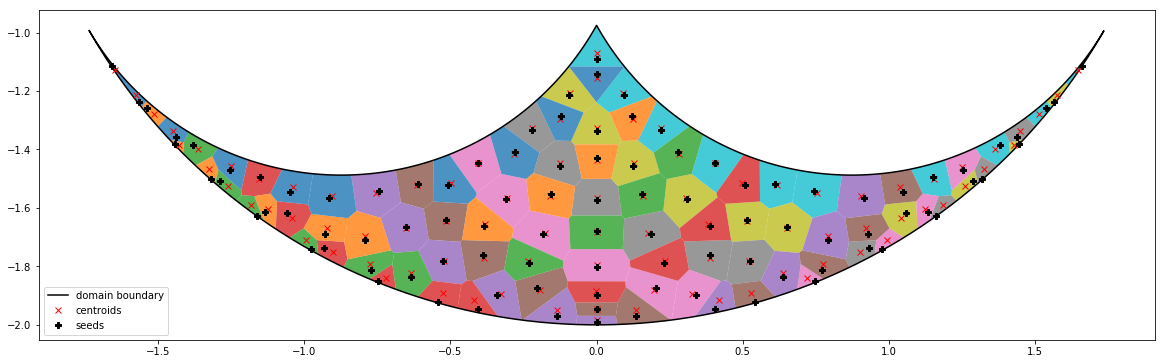

In [21]:
bfgs = spopt.minimize(FoK, initial_Phi, method = 'BFGS', jac = grad_FoK, args = (W, c0, f0, m))
print("Succes: ", bfgs['success'])
print('Number of iterations: ', bfgs['nit'])
PhiS_bfgs, PhiR_bfgs = Phi_extraction(bfgs['x'], m)
K_bfgs = wavenumbers_components_angles(PhiS_bfgs, PhiR_bfgs, c0, f0)
bfgs_seeds, bfgs_regions = voronoi_domain(K_bfgs, W)
plot_voronoi_domain(bfgs_seeds, W, bfgs_regions)

In [22]:
bfgs

      fun: 0.00390396129338313
 hess_inv: array([[ 3.53373200e+00,  2.11793758e+00,  2.23925024e+00,
         7.88585692e-01,  9.74940727e-01,  1.78348985e-01,
        -1.16900206e-01, -1.61556497e+00, -1.74823044e+00,
        -1.12474678e-02,  1.32242610e-02,  1.74735860e+00,
         1.61160937e+00,  1.22632370e-01, -1.78167570e-01,
        -9.85498682e-01, -7.82299877e-01, -2.23855674e+00,
        -2.11547848e+00, -2.53481018e+00],
       [ 2.11793758e+00,  9.66648695e+00,  6.46716753e+00,
         4.27935136e+00,  2.06888557e+00,  1.01708668e+00,
        -4.31982820e+00, -7.27135779e+00, -5.22653767e+00,
        -2.99854329e+00,  3.00602102e+00,  5.22512906e+00,
         7.25599753e+00,  4.34955701e+00, -1.01544374e+00,
        -2.11652903e+00, -4.25752043e+00, -6.46807079e+00,
        -8.65845541e+00, -2.12383535e+00],
       [ 2.23925024e+00,  6.46716753e+00,  1.75594592e+01,
         9.50456545e+00,  3.83695879e+00,  1.91956588e+00,
        -1.14695706e+01, -1.57666025e+01, -8.3

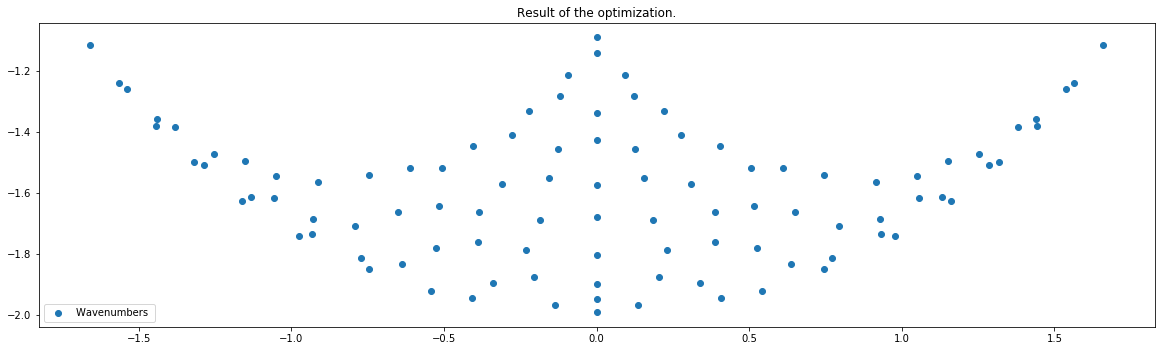

In [23]:
plot_optimization_result(bfgs['x'], m, limits, x_diffraction_pt, c0, f0)

### L-BFGS-B

Succes:  True
Number of iterations:  42


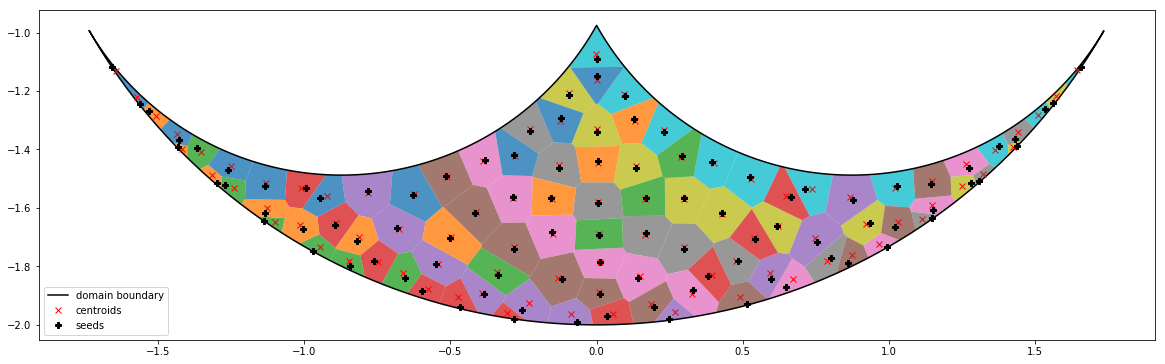

In [24]:
l_bfgs_b = spopt.minimize(FoK, initial_Phi, method = 'L-BFGS-B', jac = grad_FoK, args = (W, c0, f0, m), bounds = Bounds)
print("Succes: ", l_bfgs_b['success'])
print('Number of iterations: ', l_bfgs_b['nit'])
PhiS_l_bfgs_b, PhiR_l_bfgs_b = Phi_extraction(l_bfgs_b['x'], m)
K_l_bfgs_b = wavenumbers_components_angles(PhiS_l_bfgs_b, PhiR_l_bfgs_b, c0, f0)
l_bfgs_b_seeds, l_bfgs_b_regions = voronoi_domain(K_l_bfgs_b, W)
plot_voronoi_domain(l_bfgs_b_seeds, W, l_bfgs_b_regions)

In [25]:
l_bfgs_b

      fun: 0.0038523154296601124
 hess_inv: <20x20 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.49521310e-07,  1.00644676e-06,  3.10161906e-06,  2.78194156e-06,
       -1.70240312e-06,  3.53191462e-06,  7.12702397e-06,  1.15369052e-06,
        2.97615780e-06, -5.23963982e-06,  8.68516518e-07, -3.46788547e-06,
        7.51691659e-06,  6.06816404e-06,  5.09415149e-06, -8.48974515e-06,
        2.98790741e-06,  9.68096639e-08,  1.29974062e-06, -1.88053467e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 54
      nit: 42
   status: 0
  success: True
        x: array([-0.99453094, -0.83525222, -0.65367078, -0.45870997, -0.31928682,
       -0.1272044 ,  0.19209441,  0.5668565 ,  0.76997696,  0.96061908,
       -0.9592546 , -0.76433629, -0.55638161, -0.15525661,  0.05828042,
        0.33059909,  0.47356915,  0.65863636,  0.8372975 ,  0.99447701])

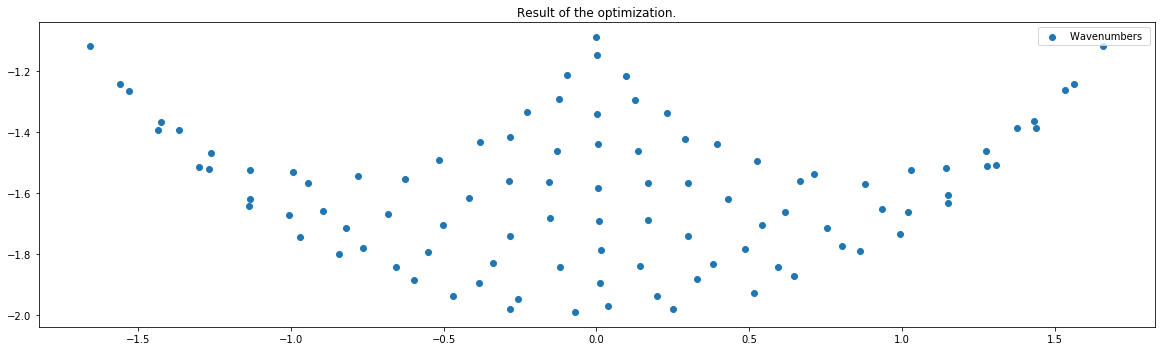

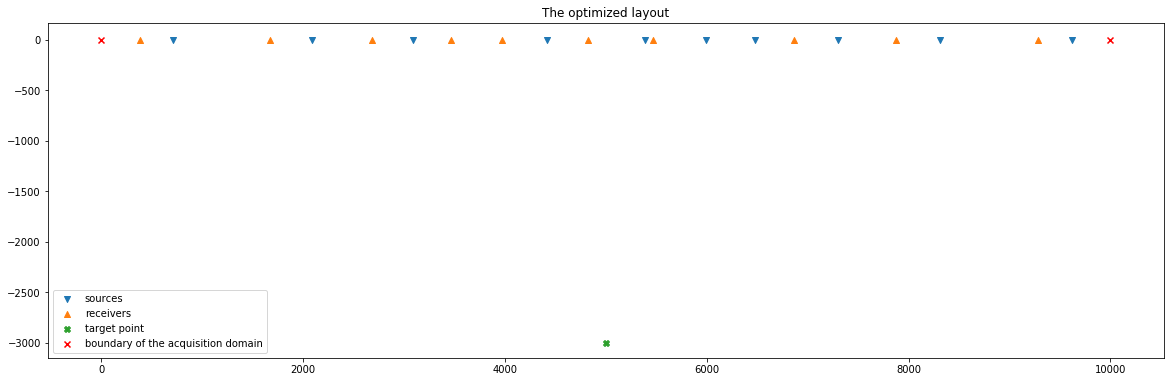

In [26]:
plot_optimization_result(l_bfgs_b['x'], m, limits, x_diffraction_pt, c0, f0)

In [27]:
print("=========== Wavenumbers W ==========")
print("---------------- value of the objective function --------------------")
print("Initial fct value: ", F(initial_K, W))
print("Lloyd fct value: ", F(lloyd_seeds, W))
print("bfgs fct value: ", F(bfgs_seeds, W))
print("l_bfgs_b fct value: ", F(l_bfgs_b_seeds, W))
print("---------------- 2-norm of the gradient --------------------")
print("Initial fct gradient: ", np.linalg.norm( grad_F(initial_K, W) ) )
print("Lloyd fct gradient: ", np.linalg.norm( grad_F(lloyd_seeds, W)) )
print("bfgs fct gradient: ", np.linalg.norm( grad_F(bfgs_seeds, W)) )
print("l_bfgs_b fct gradient: ", np.linalg.norm( grad_F(l_bfgs_b_seeds, W)) )

=========== Wavenumbers W ==========
---------------- value of the objective function --------------------
Initial fct value:  0.0049950206535794755
Lloyd fct value:  0.0027696156924408555
bfgs fct value:  0.00390396129338313
l_bfgs_b fct value:  0.0038523154296601124
---------------- 2-norm of the gradient --------------------
Initial fct gradient:  0.0026387371876836685
Lloyd fct gradient:  2.980656247797222e-05
bfgs fct gradient:  0.0033313913241801636
l_bfgs_b fct gradient:  0.0034717119570159315
